# Particle Surface Tutorial

Understanding how particle surfaces are represented is crucial in the study of condensation processes involving water and organic molecules. This is primarily influenced by the Kelvin curvature effect, which describes how the saturation vapor pressure of a liquid droplet varies with its size. This tutorial will introduce the fundamental approaches to modeling the particle surface in aerosol particle simulations.

[Kelvin Curvature Effect](https://en.wikipedia.org/wiki/Kelvin_equation)

## Strategies for Surface Representation

To accurately simulate particle surfaces, one must adhere to the `SurfaceStrategy` abstract base class. This class outlines common methods required for all surface representation strategies:

- `kelvin_radius`: Calculates the particle radius that corresponds to the Kelvin curvature effect.
- `kelvin_term`: Computes the Kelvin term, defined as exp(kelvin_radius / particle_radius).

Specifically, the strategies differ in how they calculate:

- `effective_surface_tension`: Determines the effective surface tension of species based on their concentration.
- `effective_density`: Computes the effective density of species based on their concentration.

While each strategy may require additional parameters, defining surface tension is essential for all. The primary strategies include:

- `SurfaceStrategyMolar`: Uses mole fraction weighted values to determine surface tension and density.
- `SurfaceStrategyMass`: Uses mass fraction weighted values to determine surface tension and density.
- `SurfaceStrategyVolume`: Uses volume fraction weighted values to determine surface tension and density.

Each strategy is interchangeable and suitable for use in aerosol particle simulations. The choice of strategy should be guided by the available data and the level of detail required for the simulation.

In this tutorial, we will demonstrate how to create and use these strategies, employing builders and factories to instantiate them and calculate both the Kelvin radius and term.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from particula.particles import SurfaceStrategyMolar, SurfaceStrategyMassBuilder, SurfaceFactory

## Direct Strategy Creation

The following code demonstrates how directly create and instance of a molar surface strategy and calculate the Kelvin radius and term.

Note this approach assumes base SI units, if you want conversions on the inputs and data validation checks then use the subsequent builder and factory methods.


In [2]:
glycerol_molar_mass = 0.092093 # kg/mol
glycerol_density = 1261 # kg/m^3
glycerol_surface_tension = 0.063 # N/m

# Create a surface strategy
glycerol_surface_strategy = SurfaceStrategyMolar(
    glycerol_molar_mass, glycerol_density, glycerol_surface_tension
)

glycerol_kelvin_radius = glycerol_surface_strategy.kelvin_radius(
    molar_mass=glycerol_molar_mass,
    mass_concentration=0.1,  # not this doesn't not matter for a single species mixture
    temperature=300
)

print(f"kelvin radius of glycerol {glycerol_kelvin_radius} m")

kelvin radius of glycerol 5.392780089118282e-09 m


### Kelvin term

To see the Kelvin term in action, we will calculate the Kelvin term for an array of glycerol particles. The Kelvin term is a dimensionless quantity that describes the effect of the Kelvin curvature on the saturation vapor pressure of a liquid droplet. It is defined as exp(kelvin_radius / particle_radius).

So values of the Kelvin term greater than 1 indicate that the saturation vapor pressure required to maintain the particle's size is higher than the saturation vapor pressure of the bulk liquid (flat surface). This is due to the increased in curvature of the particle surface.


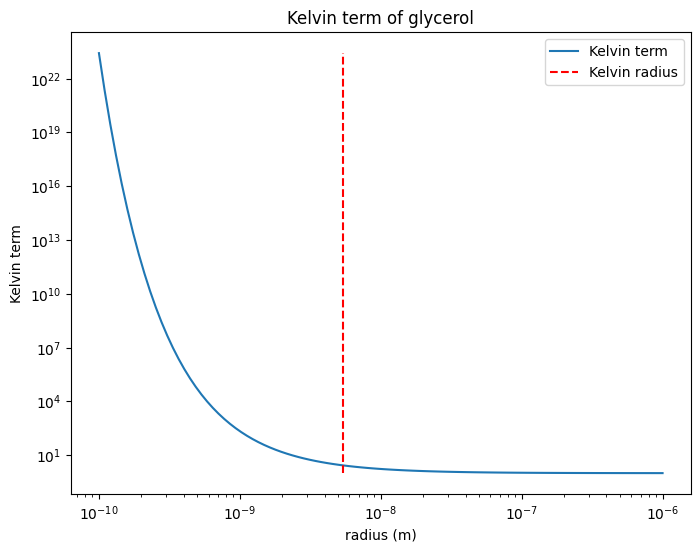

In [3]:
radii = np.logspace(-10, -6, 100)

glycerol_kevlin_term = glycerol_surface_strategy.kelvin_term(
    radius=radii,
    molar_mass=glycerol_molar_mass,
    mass_concentration=0.1,
    temperature=300
)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(radii, glycerol_kevlin_term)
ax.plot([glycerol_kelvin_radius, glycerol_kelvin_radius], [min(glycerol_kevlin_term), max(glycerol_kevlin_term)], color="red", linestyle="--")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_title("Kelvin term of glycerol")
ax.set_xlabel("radius (m)")
ax.set_ylabel("Kelvin term")
ax.legend(["Kelvin term", "Kelvin radius"])
plt.show()

## Builder for Squalane

The following code demonstrates how to use the builder to create a surface strategy for squalane particles. The builder allows for the specification of the surface tension and density of the species, as well as the concentration of the species in the particle.

Squalane is a larger molecule with a lower surface tension than glycerol, so the Kelvin term will be lower for the same particle size.

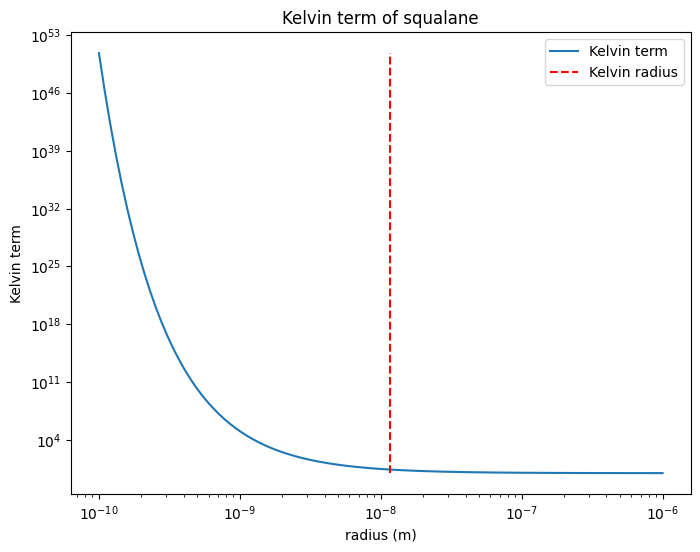

In [4]:
squalane_surface = (
    SurfaceStrategyMassBuilder()
    .set_density(0.81, density_units="g/cm^3")  # call with parameter name
    .set_surface_tension(28, "mN/m")  # call without parameter name
    .build()
)

# create plot
squalane_kelvin_radius = squalane_surface.kelvin_radius(
    molar_mass=0.422, mass_concentration=0.1, temperature=300
)
squalane_kelvin_term = squalane_surface.kelvin_term(
    radius=radii, molar_mass=0.422, mass_concentration=0.1, temperature=300
)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(radii, squalane_kelvin_term)
ax.plot([squalane_kelvin_radius, squalane_kelvin_radius], [min(squalane_kelvin_term), max(squalane_kelvin_term)], color="red", linestyle="--")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_title("Kelvin term of squalane")
ax.set_xlabel("radius (m)")
ax.set_ylabel("Kelvin term")
ax.legend(["Kelvin term", "Kelvin radius"])
plt.show()



## Factory Approach

Next example is the creation using a factory method, which is more flexible and allows for the use of different units and conversions. The factory method also performs data validation checks to ensure the input values are within the expected range. As the factory is just a wrapper around the builder, the same parameters can/must be used.

Here we'll create a mixture of glycerol and squalane particles, and calculate the Kelvin term for a range of particle sizes for a volume fraction of 0.5 for each species. And assume glycerol is the condensing species.

[double check the graph output, if the mixture should be lower than the pure or not]

kelvin radius of mixture 3.1208511801897936e-09 m


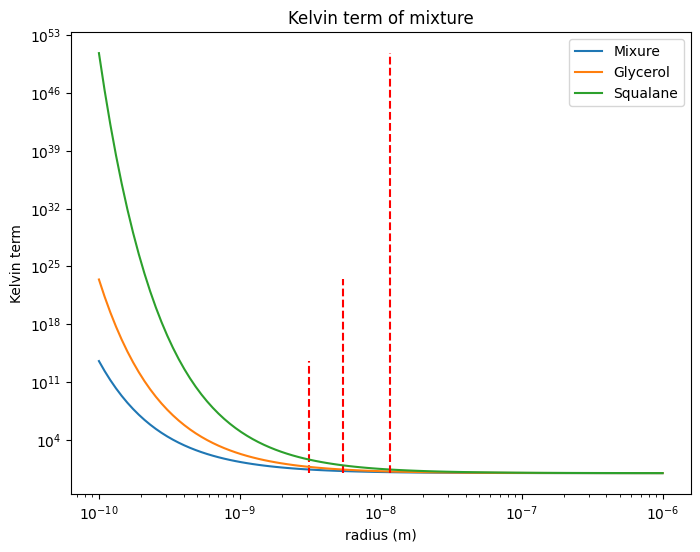

In [5]:
parameters = {  # glycerol, squalane
        "density": np.array([1261, 810]),  # kg/m^3
        "surface_tension": np.array([0.063, 0.028]),  # N/m
}

mixture_surface = SurfaceFactory().get_strategy(
    strategy_type="volume",
    parameters=parameters,
)

mixture_kelvin_radius = mixture_surface.kelvin_radius(
    molar_mass=0.092093,
    mass_concentration=np.array([0.1, 0.1]),
    temperature=300
)
print(f"kelvin radius of mixture {mixture_kelvin_radius} m")

mixture_kelvin_term = mixture_surface.kelvin_term(
    radius=radii,
    molar_mass=0.092093,
    mass_concentration=np.array([0.1, 0.1]),
    temperature=300
)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(radii, mixture_kelvin_term, label="Mixure")
ax.plot([mixture_kelvin_radius, mixture_kelvin_radius], [min(mixture_kelvin_term), max(mixture_kelvin_term)], color="red", linestyle="--")
ax.plot(radii, glycerol_kevlin_term, label="Glycerol")
ax.plot([glycerol_kelvin_radius, glycerol_kelvin_radius], [min(glycerol_kevlin_term), max(glycerol_kevlin_term)], color="red", linestyle="--")
ax.plot(radii, squalane_kelvin_term, label="Squalane")
ax.plot([squalane_kelvin_radius, squalane_kelvin_radius], [min(squalane_kelvin_term), max(squalane_kelvin_term)], color="red", linestyle="--")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_title("Kelvin term of mixture")
ax.set_xlabel("radius (m)")
ax.set_ylabel("Kelvin term")
ax.legend()
plt.show()


# Summary

This tutorial has demonstrated the fundamental approaches to modeling particle surfaces in aerosol particle simulations. By using the `SurfaceStrategy` abstract base class, we can create and use different strategies to calculate the Kelvin radius and term. The choice of strategy should be guided by the available data and the level of detail required for the simulation.

The `SurfaceStrategyMolar`, `SurfaceStrategyMass`, and `SurfaceStrategyVolume` strategies provide flexibility in determining the effective surface tension and density of species based on their concentration. By using builders and factories, we can create surface strategies with the necessary parameters and perform data validation checks to ensure the input values are within the expected range.